In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

The first minima found is [-0.08984202  0.71265641] with value: -1.0316284534898768
The second minima found is [ 0.08984201 -0.71265642] with value: -1.0316284534898743
The minima with initial guess (0, 0) is [0. 0.]


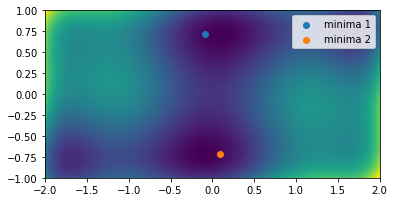

In [40]:
def f(X):
    x = X[0]
    y = X[1]
    return (4-2.1*x**2+x**4/3)*x**2+x*y+(4*y**2-4)*y**2

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)

mesh = np.meshgrid(x, y)
plt.imshow(f(mesh), extent=(-2, 2, -1, 1))

# fin global minima of this function
minima_list = []
minima = minimize(f, (0, 0.75))
print("The first minima found is", minima["x"], "with value:", minima["fun"])
plt.scatter(minima["x"][0], minima["x"][1], label="minima 1")
minima_list.append(minima)

minima = minimize(f, (0, -0.75))
print("The second minima found is", minima["x"], "with value:", minima["fun"])
plt.scatter(minima["x"][0], minima["x"][1], label="minima 2")
minima_list.append(minima)

# What happens for an initial guess of (x, y) = (0, 0)?
solution = minimize(f, (0, 0))
print("The minima with initial guess (0, 0) is", solution["x"])

plt.legend()

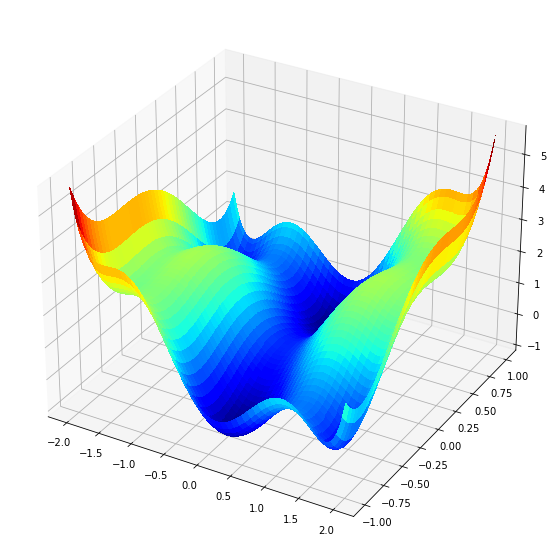

In [51]:
# Plot the surface for a better interpretation
#%matplotlib widget
%matplotlib inline

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
surf = ax.plot_surface(mesh[0], mesh[1], f(mesh), cmap="jet",
                       linewidth=0, antialiased=False)

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Time offset for maxT: 6.74+-0.08
Time offset for minT: 7.16+-0.05

 Compability between the two: 4.6 => they are not the same within the fit accuracy


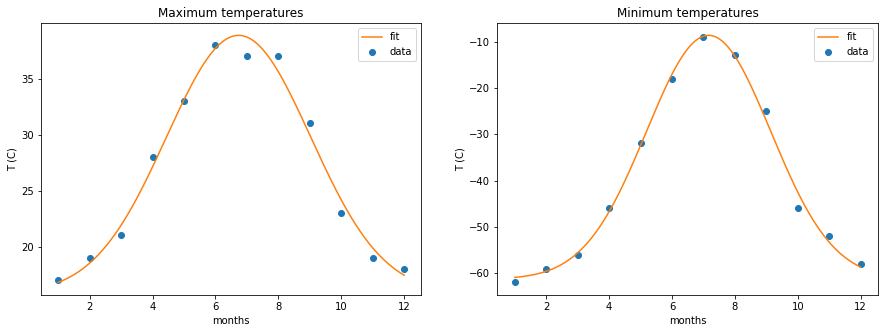

In [271]:
months = [i for i in range(1,13)]
maxT = [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
minT = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

# Plot these temperature extremes
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].scatter(months, maxT, label="data")
axes[0].set_title("Maximum temperatures")
axes[0].set_xlabel("months")
axes[0].set_ylabel("T (C)")

axes[1].scatter(months, minT, label="data")
axes[1].set_title("Minimum temperatures")
axes[1].set_xlabel("months")
axes[1].set_ylabel("T (C)")

# Define a function that can describe min and max temperatures
def gaussian(x, A, mu, std, c):
    return A*np.exp(-(x-mu)**2/(2*std**2))+c

# Fit this function to the data with scipy.optimize.curve_fit()
p0_M = [40, 7, 4, 0]
popt_M, pcov_M= curve_fit(gaussian, months, maxT, p0_M)

p0_m = [50, 7, 4, -60]
popt_m, pcov_m= curve_fit(gaussian, months, minT, p0_m)

# Plot the result
x = np.linspace(1, 12, 1000)

axes[0].plot(x, gaussian(x, *popt_M), c="tab:orange", label="fit")
axes[0].legend()
axes[1].plot(x, gaussian(x, *popt_m), c="tab:orange", label="fit")
axes[1].legend()

# Is the time offset for min and max temperatures the same within the fit accuracy?
print("Time offset for maxT: %4.2f+-%4.2f"%(popt_M[1], np.sqrt(pcov_M[1,1])))
print("Time offset for minT: %4.2f+-%4.2f"%(popt_m[1], np.sqrt(pcov_m[1,1])))
comp = abs(popt_M[1]-popt_m[1])/np.sqrt(pcov_m[1,1]+pcov_M[1,1])
print("\n Compability between the two: %3.1f => they are not the same within the fit accuracy"%(comp))



In [273]:
# goodness of the fit
residuals = maxT- gaussian(months, *popt_M)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((maxT-np.mean(maxT))**2)
r_squared_M = 1 - (ss_res/ss_tot)

residuals = minT- gaussian(months, *popt_m)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((minT-np.mean(minT))**2)
r_squared_m = 1 - (ss_res/ss_tot)

print("The fit is good? Look at R^2: \n maxT->%4.3f \n minT->%4.3f \nIt seems good"%(r_squared_M, r_squared_m))

The fit is good? Look at R^2: 
 maxT->0.986 
 minT->0.995 
It seems good


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [59]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P ./data/ -nv

2021-12-15 15:58:45 URL:https://ucfea7815d98b061f5ce54f5a684.dl.dropboxusercontent.com/cd/0/inline2/Bb5WeDO4TVZJ5iWcFqtq2D8ANpZQGdOYPEHwkUW8Mj1C3acxkruMG656yRqyNaq1FGH9YWTgWzs7u-k0hFfVBVKoTJw8MNjarmzH1Wx57Rwd9PPg-YWc0lpbAkw2-y6bNahmrb0Lb0S_sCVnxd_rMHAQWINa4pjCyTDZFBzTourWYMBDN0DHO5iXm17yLFB4ODHhsiukV_Yh1WfV8avt9OGq204bHT_PM8syA9BRLBDQ-w1D5NG6OiZcQ5JYXtuywWspmSUF5IPo3BAp6fiAPo-djhLQOHz_54t-Kx0IShEC7LGZs8jNf3WD1ywoVu3yib4LbE4kj4vpCEvK5VmUNGk6AG4RdZd9G28Uc0UIpzrGqK_y059WBnRK0G74RIertMw/file [178390/178390] -> "./data/residuals_261.pkl" [1]


In [117]:
import pickle
import pandas as pd

# reading data
with open('data/residuals_261.pkl', 'rb') as f:
        data = pickle.load(f)

data = pd.DataFrame.from_dict(data.item())


In [180]:
def gaussian(x, A, mu, std):
    return A*np.exp(-(x-mu)**2/(2*std**2))
def lorentzian(x, A, x0, gamma):
    return A*gamma**2/(gamma**2+(x-x0)**2)
def voigt(x, amplG, mu, std, amplL, x0, gamma):
    return gaussian(x, amplG, mu, std)+lorentzian(x, amplL, x0, gamma)

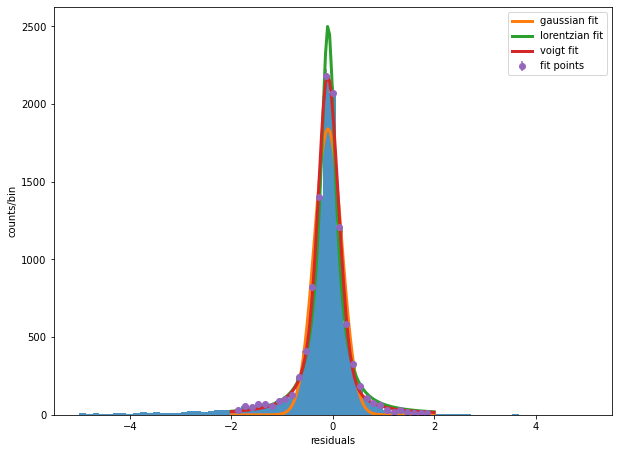

In [209]:
fig, ax = plt.subplots(figsize=(10,7.5))
# build datapoints for hist
counts, bins, _ = plt.hist(data['residuals'], bins=75, range=(-5, 5), alpha=0.8)
x_points = np.array([(x1+x2)*0.5 for x1, x2 in zip(bins[:-1], bins[1:])])
err      = np.array([np.sqrt(n) for n in counts])
counts   = np.array(counts)

# select only a tailored range for the fit
idx = np.array([ i for i in range(len(x_points)) if(-2<x_points[i]<2)])
x_points = x_points[idx]
counts   = counts[idx]
err      = err[idx]

p0 = [1600, 0, 1]
popt_gaus, pcov_gaus = curve_fit(gaussian, x_points, counts, p0, err)
popt_lor, pcov_lor = curve_fit(lorentzian, x_points, counts, p0, err)
p0_ = [1000, 0, 1, 60, 0, 1]
popt_voigt, pcov_voigt = curve_fit(voigt, x_points, counts, p0_, err)

x = np.linspace(-2, 2, 100)
plt.plot(x, gaussian(x, *popt_gaus), lw=3, label='gaussian fit')
plt.plot(x, lorentzian(x, *popt_lor), lw=3, label='lorentzian fit')
plt.plot(x, voigt(x, *popt_voigt), lw=3, label='voigt fit')
plt.errorbar(x_points, counts, err, fmt='o', label='fit points')
plt.xlabel('residuals')
plt.ylabel('counts/bin')
plt.legend()
plt.show()

n degrees of freedom = 26
chi2 = 122.54914021194791
p-value = 1.7763568394002505e-14


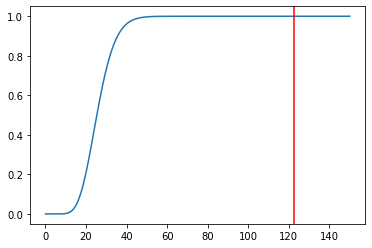

In [213]:
from scipy import stats
# perfrom a goodness of the fit test
ndof = len(x_points) - 3
print("n degrees of freedom =", ndof)
# calculate the chi^2
chi2 = np.sum(((counts - voigt(x_points, *popt_voigt))**2)/err**2)
print("chi2 =", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue)
x = np.linspace(0,150,1000)
plt.plot(x, stats.chi2.cdf(x, df=ndof))
plt.fill_between(x_points, counts, where=(x_points > chi2), color='lightblue')
plt.axvline(chi2, color='r')
plt.show()

P value is too small, the test is not satisfactory, "too good to be true". The RSS is very high and this causes a value of chi2 higher than expected

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

In [214]:
!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt -nv -P ./data/

2021-12-15 22:24:04 URL:https://uc329ba4225def764dc698a92437.dl.dropboxusercontent.com/cd/0/inline/Bb7JX4QQ6xH1JLO6tV0Llslo8ds495rGh3e8k7Og1h4UUva9K0L_l_RtJduDRWYtvi6RAEgpCbC8zHxv-fdxt5C8CKM8C_xn0ITknEJq4bCUyTMeFTpetteYiK9XucI8OAhwQj_7R0NhzwA8CehWQBr8/file [125482/125482] -> "./data/munich_temperatures_average_with_bad_data.txt" [1]


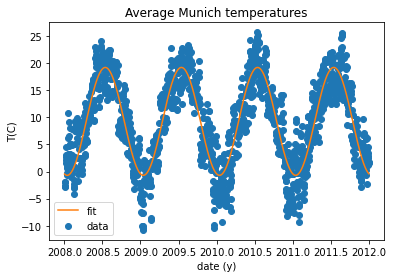

Best fit parameters: [a, b, c] = [-9.96203468 -0.23462776  9.26282131]
Overall average temperature: T* = 8.933 C
Hottest time of the year: Effective temperature =  27.667 C, Predicted temperature = 18.032 C
Coldest time of the year: Effective temperature = -16.778 C, Predicted temperature = -0.510 C


In [264]:
date, temperature = np.loadtxt('data/munich_temperatures_average_with_bad_data.txt', unpack=True)

# fit function
def f(t, a, b, c):
    return a*np.cos(t*2*np.pi+b)+c

# remove outliers
idx = np.abs(temperature)<90
date = date[idx]
temperature = temperature[idx]

# select only a certain range for the fit
idx = np.array([ i for i in range(len(date)) if(2008<=date[i]<=2012)])
x = date[idx]
y = temperature[idx]

# perfrom the fit
p0 = [15, 0, 7]
popt, pcov = curve_fit(f, x, y, p0)

plt.scatter(x, y, label="data")
plt.plot(x, f(x, *popt), c="tab:orange", label="fit")
plt.title("Average Munich temperatures")
plt.xlabel("date (y)")
plt.ylabel("T(C)")
plt.legend()
plt.show()

print("Best fit parameters: [a, b, c] =", popt)
print("Overall average temperature: T* = %5.3f C"%(np.mean(temperature)))
print("Hottest time of the year: Effective temperature =  %6.3f C, Predicted temperature = %6.3f C"%(max(temperature), f(date[np.argmax(temperature)], *popt)))
print("Coldest time of the year: Effective temperature = %6.3f C, Predicted temperature = %6.3f C"%(min(temperature), f(date[np.argmin(temperature)], *popt)))

$b$ parameter models the horizontal shift of the temperature distribution, it matches the temperatures with the correct period of the year -> higher temperatures in summer (0.5 year) lower temperatures in winter.

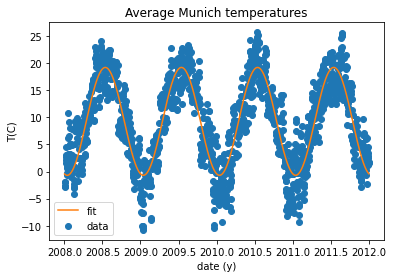

In [267]:
# fit function
def g(t, a, b, c, d):
    return a*np.cos(t*2*np.pi*b+c)+d

# perfrom the fit
p0_ = [15, 1, 0, 7]
popt_, pcov_ = curve_fit(g, x, y, p0_)

plt.scatter(x, y, label="data")
plt.plot(x, g(x, *popt_), c="tab:orange", label="fit")
plt.title("Average Munich temperatures")
plt.xlabel("date (y)")
plt.ylabel("T(C)")
plt.legend()
plt.show()

In [269]:
#What are the RSS for $f(x)$ and $g(x)$?
rss_f = np.sum((y-f(x, *popt))**2)
rss_g = np.sum((y-g(x, *popt_))**2)
print("RSS for f: %3.2f, RSS for g:  %3.2f "%(rss_f, rss_g))

# Use the Fisher F-test to determine whether the additional parameter is necessary
def Ftest(rss_1, rss_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((rss_1 - rss_2)/(ndof_2 - ndof_1)) / (rss_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

cl_f_vs_g = Ftest(rss_f, rss_g, 3-1, 4-1, len(x), verbose=True)


RSS for f: 18669.52, RSS for g:  18669.23 
CL: 0.880 , additional parameter necessary: NO
